# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.decomposition import PCA

# Data Loading

In [2]:
# Set Style
class style:
    boldStart = '\033[1m'
    boldEnd = '\033[0m'

In [3]:
# Loading Training Dataset
# Add headers to Dataset
trainData = "adult.data"
dataHeaders = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex","capital-gain","capital-loss","hours-per-week","native-country","income"]
trainSet = pd.read_csv(trainData, sep=',', names=dataHeaders)
trainSet.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# Loading Training Dataset, Skipped first row with invalid data
testData = "adult.test"
testSet = pd.read_csv(testData, sep=',',skiprows =1, names=dataHeaders)
testSet.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.


# Data Pre-Processing

In [5]:
# Removed extra spaces in string columns
trainSet = trainSet.applymap(lambda x: x.strip() if isinstance(x, str) else x)
testSet = testSet.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Target class is binary, updating table for classification
testSet["income"]=testSet["income"].replace(">50K.",1)
testSet["income"]=testSet["income"].replace("<=50K.",0)
trainSet["income"]=trainSet["income"].replace(">50K",1)
trainSet["income"]=trainSet["income"].replace("<=50K",0)

# Feature Subset Selection
# Redundant features: Education and Education num are same with different representation, dropping one
trainSet=trainSet.drop("education-num",axis=1)
testSet=testSet.drop("education-num",axis=1)

In [6]:
#Checking Training Dataset to see distribution of income Group
records = trainSet.shape[0]
records_g50 = trainSet[trainSet["income"] == 1].shape[0]
records_b50 = trainSet[trainSet["income"] == 0].shape[0]
records_g50_precent = records_g50/records*100
print("Training Set, number of records: {}".format(records))
print("Training Set, income greater than 50K: {}".format(records_g50))
print("Training Set, income below or equal to 50K: {}".format(records_b50))
print("Training Set, Percentage of people with income greater than 50K: {}%".format(records_g50_precent))
print("")

#Checking Test Dataset to see distribution of income Group
records = testSet.shape[0]
records_g50 = testSet[testSet["income"] == 1].shape[0]
records_b50 = testSet[testSet["income"] == 0].shape[0]
records_g50_precent = records_g50/records*100
print("Test Set, number of records: {}".format(records))
print("Test Set, income greater than 50K: {}".format(records_g50))
print("Test Set, income below or equal to 50K: {}".format(records_b50))
print("Test Set, Percentage of people with income greater than 50K: {}%".format(records_g50_precent))

Training Set, number of records: 32561
Training Set, income greater than 50K: 7841
Training Set, income below or equal to 50K: 24720
Training Set, Percentage of people with income greater than 50K: 24.080955744602438%

Test Set, number of records: 16281
Test Set, income greater than 50K: 3846
Test Set, income below or equal to 50K: 12435
Test Set, Percentage of people with income greater than 50K: 23.622627602727107%


In [7]:
# Missing values are noticed in both training and test data with ? format
# Replacing missing values with null in Training set
trainSet.replace({'?':np.nan},inplace=True)
trainSet.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [8]:
#Since missing values are not very huge, we can drop them
trainSet = trainSet.dropna()
trainSet.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [9]:
# Replacing missing values with null in Test set
testSet.replace({'?':np.nan},inplace=True)
testSet.isnull().sum()

age                 0
workclass         963
fnlwgt              0
education           0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
dtype: int64

In [10]:
#Since missing values are not very huge, we can drop them
testSet = testSet.dropna()
testSet.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [11]:
# Checking for duplicates in both training and test set.
# Drop duplicates
print("Training Set, number of duplicate records: {}".format(trainSet.duplicated().sum()))
trainSet = trainSet.drop_duplicates(keep='first')
print("Test Set, number of duplicate records: {}".format(testSet.duplicated().sum()))
testSet = testSet.drop_duplicates(keep='first')

Training Set, number of duplicate records: 23
Test Set, number of duplicate records: 5


In [12]:
# Reverifying training dataset
records = trainSet.shape[0]
records_g50 = trainSet[trainSet["income"] == 1].shape[0]
records_b50 = trainSet[trainSet["income"] == 0].shape[0]
records_g50_precent = records_g50/records*100
print("Training Set, number of records: {}".format(records))
print("Training Set, income greater than 50K: {}".format(records_g50))
print("Training Set, income below or equal to 50K: {}".format(records_b50))
print("Training Set, Percentage of people with income greater than 50K: {}%".format(records_g50_precent))
print("")

Training Set, number of records: 30139
Training Set, income greater than 50K: 7506
Training Set, income below or equal to 50K: 22633
Training Set, Percentage of people with income greater than 50K: 24.904608646604068%



In [13]:
# Reverifying test dataset
records = testSet.shape[0]
records_g50 = testSet[testSet["income"] == 1].shape[0]
records_b50 = testSet[testSet["income"] == 0].shape[0]
records_g50_precent = records_g50/records*100
print("Test Set, number of records: {}".format(records))
print("Test Set, income greater than 50K: {}".format(records_g50))
print("Test Set, income below or equal to 50K: {}".format(records_b50))
print("Test Set, Percentage of people with income greater than 50K: {}%".format(records_g50_precent))

Test Set, number of records: 15055
Test Set, income greater than 50K: 3700
Test Set, income below or equal to 50K: 11355
Test Set, Percentage of people with income greater than 50K: 24.57655264031883%


In [14]:
# Checking Training dataset features
trainSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30139 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30139 non-null  int64 
 1   workclass       30139 non-null  object
 2   fnlwgt          30139 non-null  int64 
 3   education       30139 non-null  object
 4   marital-status  30139 non-null  object
 5   occupation      30139 non-null  object
 6   relationship    30139 non-null  object
 7   race            30139 non-null  object
 8   sex             30139 non-null  object
 9   capital-gain    30139 non-null  int64 
 10  capital-loss    30139 non-null  int64 
 11  hours-per-week  30139 non-null  int64 
 12  native-country  30139 non-null  object
 13  income          30139 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 3.4+ MB


In [15]:
# Checking Test dataset features
testSet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15055 entries, 0 to 16280
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15055 non-null  int64 
 1   workclass       15055 non-null  object
 2   fnlwgt          15055 non-null  int64 
 3   education       15055 non-null  object
 4   marital-status  15055 non-null  object
 5   occupation      15055 non-null  object
 6   relationship    15055 non-null  object
 7   race            15055 non-null  object
 8   sex             15055 non-null  object
 9   capital-gain    15055 non-null  int64 
 10  capital-loss    15055 non-null  int64 
 11  hours-per-week  15055 non-null  int64 
 12  native-country  15055 non-null  object
 13  income          15055 non-null  int64 
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


# Exploratory Data Analysis

In [16]:
# Let us further explore on data, first by numerical values and then categorical values
trainSet.describe()
# Capital-gain and capiltal-loss seems to have huge outliers, we will explore further

,age,fnlwgt,capital-gain,capital-loss,hours-per-week,income
count,30139.000000,3.013900e+04,30139.000000,30139.000000,30139.000000,30139.000000
mean,38.441720,1.897950e+05,1092.841202,88.439928,40.934703,0.249046
std,13.131426,1.056586e+05,7409.110596,404.445239,11.978753,0.432468
min,17.000000,1.376900e+04,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.176275e+05,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.784170e+05,0.000000,0.000000,40.000000,0.000000
75%,47.000000,2.376045e+05,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,99999.000000,4356.000000,99.000000,1.000000


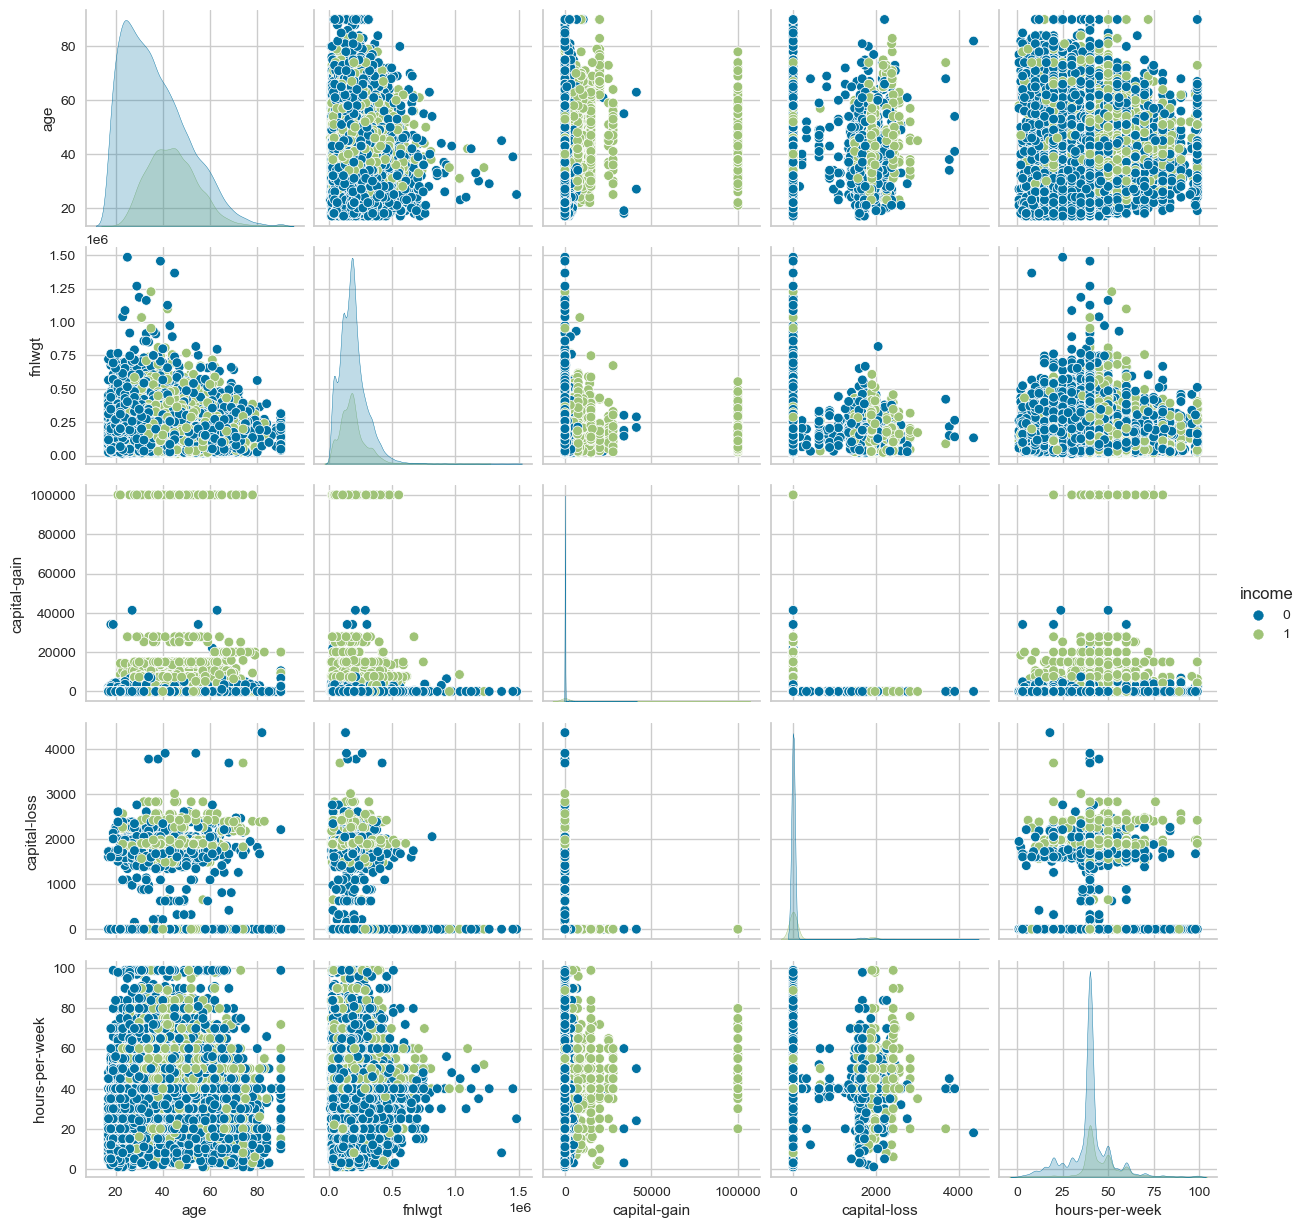

In [17]:
sns.pairplot(trainSet, hue="income")
# Capital-gain and capiltal-loss seems to be negatively correlated

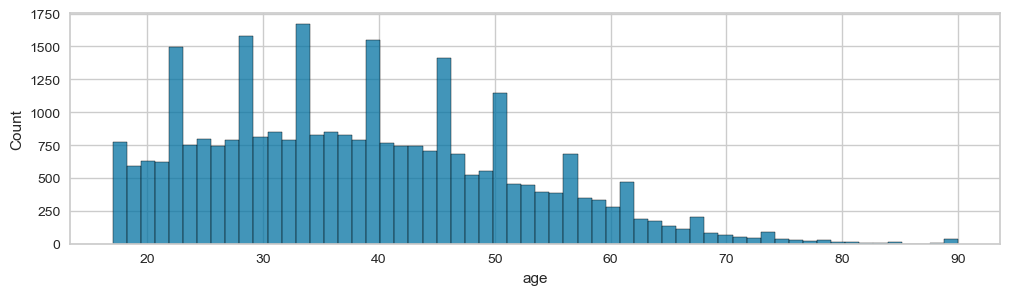

Age >60: 1805
Age <60: 1365


In [18]:
plt.figure(figsize=(12,3))
sns.histplot(trainSet["age"],kde=False)
plt.show()
print("Age >60: {}".format(trainSet[trainSet["age"] > 60].shape[0]))
print("Age <60: {}".format(trainSet[trainSet["age"] < 20].shape[0]))
# Age seems right skewed
# Data for elders above age 60 is less, not an issue
# Data for age below 20 is also less, which is normal

<function matplotlib.pyplot.show(close=None, block=None)>

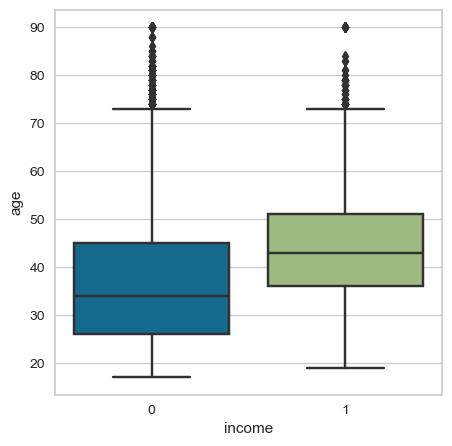

In [19]:
fig = plt.figure(figsize=(5,5))
sns.boxplot(x="income",y="age",data=trainSet)
plt.show
# Income group >50k has higher median age compared to Income group <=50k.

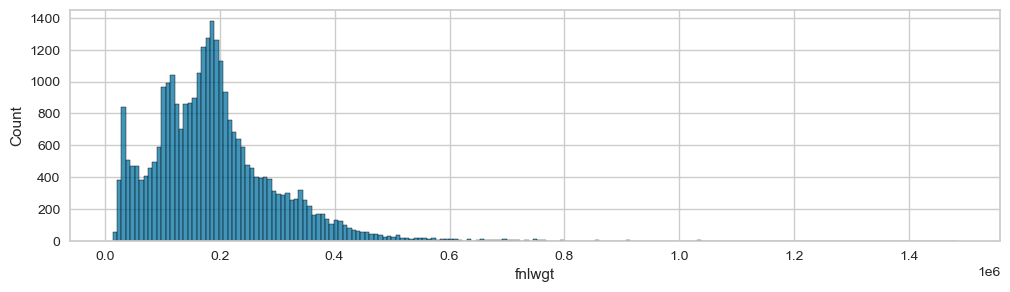

In [20]:
plt.figure(figsize=(12,3))
sns.histplot(trainSet["fnlwgt"],kde=False)
plt.show()
# fnlwgt seems right skewed

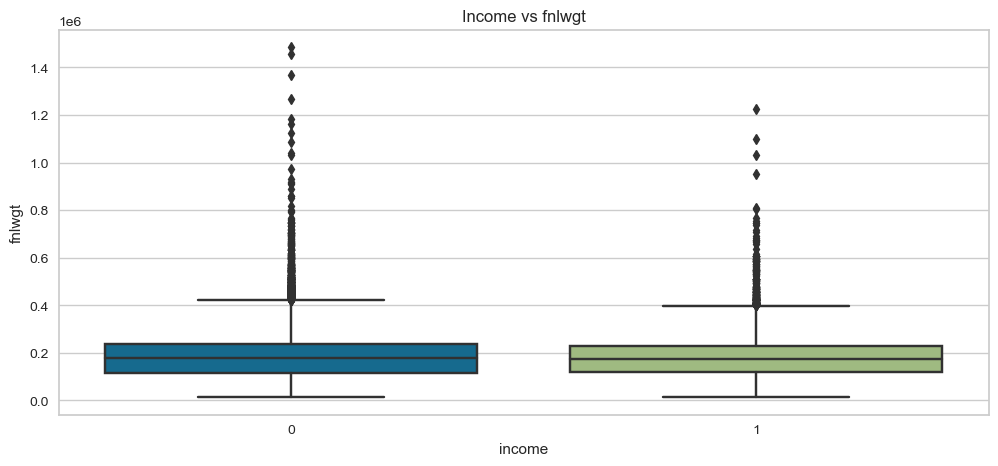

In [21]:
plt.figure(figsize=(12,5))
sns.boxplot(x="income",y="fnlwgt",data=trainSet).set_title("Income vs fnlwgt")
plt.show()
# Feature Subset Selection
# Irrelevant features: fnlwgt, weight seems to have no impact on income prediction. Dropping fnlwgt column
trainSet=trainSet.drop("fnlwgt",axis=1)
testSet=testSet.drop("fnlwgt",axis=1)

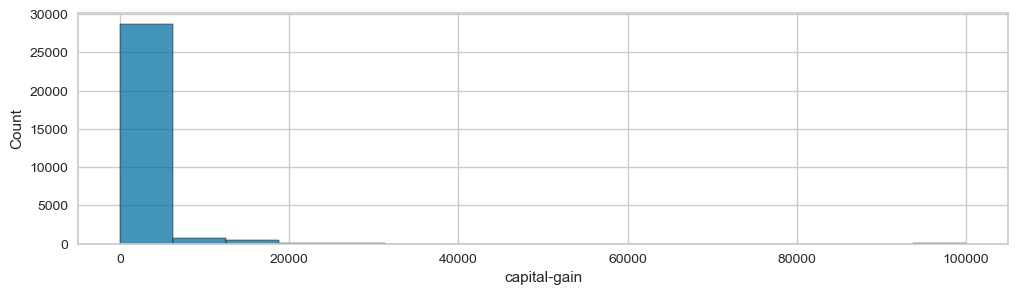

In [22]:
plt.figure(figsize=(12,3))
sns.histplot(trainSet["capital-gain"],kde=False)
plt.show()

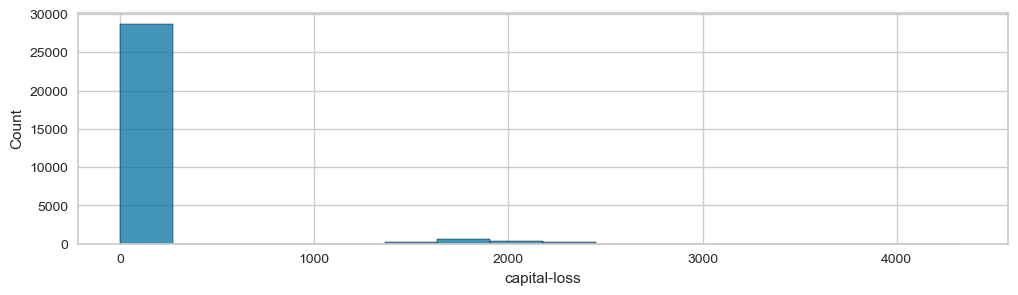

In [23]:
plt.figure(figsize=(12,3))
sns.histplot(trainSet["capital-loss"],kde=False)
plt.show()

In [24]:
# In majority of data, capital gain and capital loss is 0 which mean less percent of people invest
# Also capital gain and capital loss seems to be very high for those who have gain or loss
# Capital loss and gain seems to be correlated as well
print("Capital Gain: {}".format(trainSet[trainSet["capital-gain"] == 0].shape[0]))
print("Capital Loss: {}".format(trainSet[trainSet["capital-loss"] == 0].shape[0]))
print("Capital Loss and Capital Gain are 0: {}".format(trainSet[(trainSet["capital-loss"] == 0) & (trainSet["capital-gain"] == 0)].shape[0]))
print("Capital Loss >0 and Income group <=50K: {}".format(trainSet[(trainSet["capital-loss"] > 0) & (trainSet["income"] == 0)].shape[0]))
print("Capital Loss >0 and Income group >50k: {}".format(trainSet[(trainSet["capital-loss"] > 0) & (trainSet["income"] == 1)].shape[0]))
print("Capital Gain >0 and Income group <=50k: {}".format(trainSet[(trainSet["capital-gain"] > 0) & (trainSet["income"] == 0)].shape[0]))
print("Capital Gain >0 and Income group >50k: {}".format(trainSet[(trainSet["capital-gain"] > 0) & (trainSet["income"] == 1)].shape[0]))

Capital Gain: 27601
Capital Loss: 28712
Capital Loss and Capital Gain are 0: 26174
Capital Loss >0 and Income group <=50K: 690
Capital Loss >0 and Income group >50k: 737
Capital Gain >0 and Income group <=50k: 943
Capital Gain >0 and Income group >50k: 1595


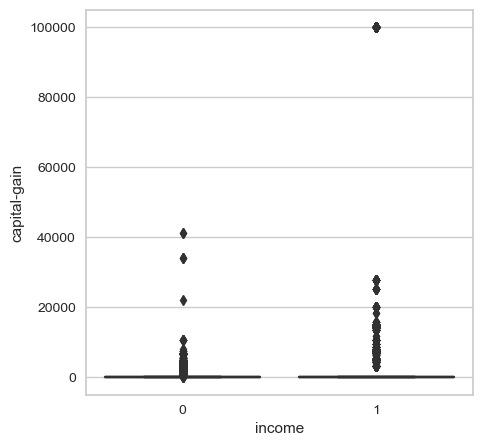

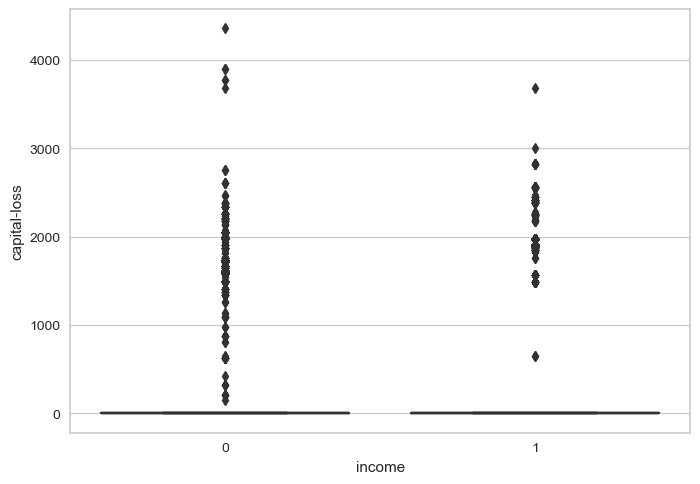

Capital Gain: 148
Capital Loss: 8


In [25]:
plt.figure(figsize=(5,5))
sns.boxplot(x="income", y="capital-gain", data=trainSet)
plt.show()
sns.boxplot(x="income", y="capital-loss", data=trainSet)
plt.show()
print("Capital Gain: {}".format(trainSet[trainSet["capital-gain"] > 80000].shape[0]))
print("Capital Loss: {}".format(trainSet[trainSet["capital-loss"] > 3000].shape[0]))

              capital-gain  capital-loss
capital-gain      1.000000     -0.032255
capital-loss     -0.032255      1.000000


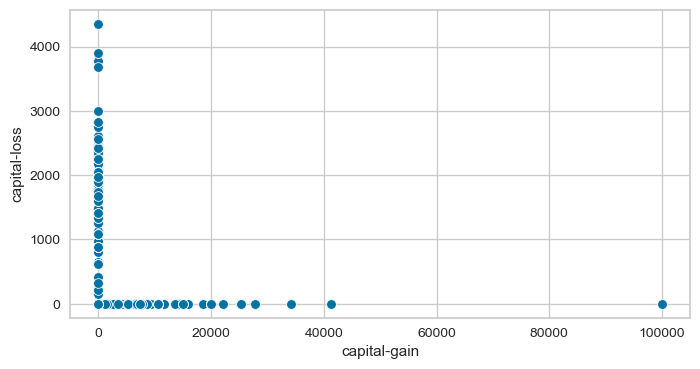

In [26]:
print(trainSet[["capital-gain","capital-loss"]].corr())
plt.figure(figsize=(8,4))
sns.scatterplot(x=trainSet["capital-gain"],y=trainSet["capital-loss"])
plt.show()
# Since capital-gain and capital loss are negatively correlated, we will drop capital-gain
# We will also replace outliers in capital-loss with mean value.
trainSet=trainSet.drop("capital-gain",axis=1)
testSet=testSet.drop("capital-gain",axis=1)

In [27]:
trainSet["capital-loss"].mean()
trainSet["capital-loss"] = np.where((trainSet["capital-loss"] > 3000), trainSet["capital-loss"].mean(), trainSet["capital-loss"])

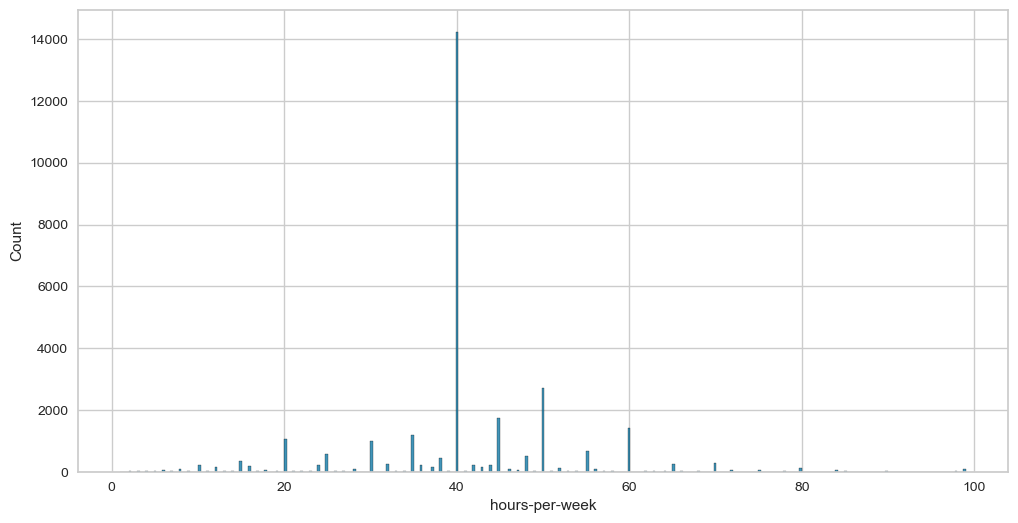

Working below 20 hours per week: 1330
Working above 60 hours per week: 1052


In [28]:
plt.figure(figsize=(12,6))
sns.histplot(trainSet["hours-per-week"],kde=False)
plt.show()
print("Working below 20 hours per week: {}".format(trainSet[trainSet["hours-per-week"] <20].shape[0]))
print("Working above 60 hours per week: {}".format(trainSet[trainSet["hours-per-week"] >60].shape[0]))
# Majority of people work around 40 Hrs.
# There are some people who work below 20Hrs per week and above 60Hrs per week which is not very common

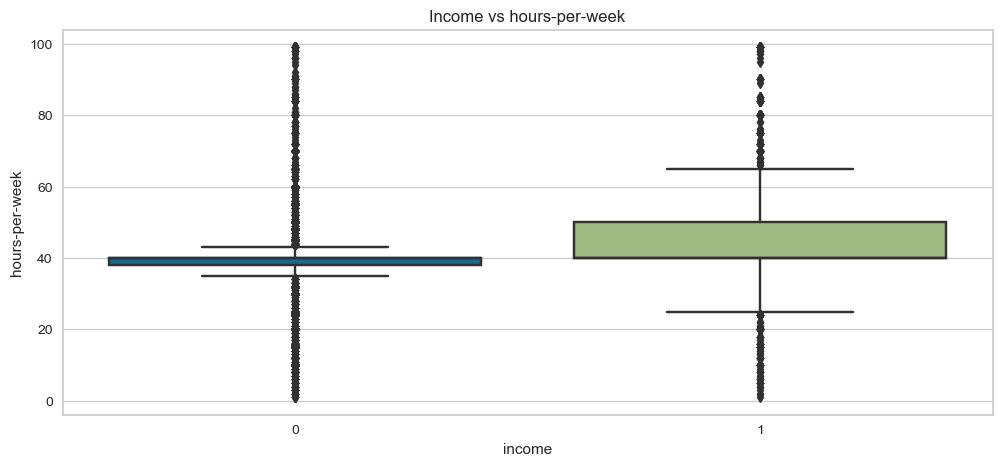

In [29]:
plt.figure(figsize=(12,5))
sns.boxplot(x="income",y="hours-per-week",data=trainSet).set_title("Income vs hours-per-week")
plt.show()
# Income group >50k works higher median hours compared to Income group <=50k. 

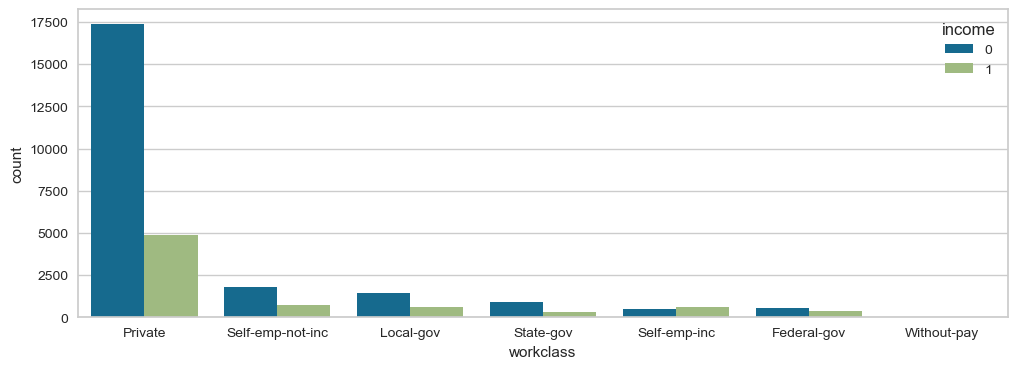

In [30]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="workclass",hue="income",order=trainSet["workclass"].value_counts().index)
plt.show()
# Most peope are working in private sector for both income group, very less number of people without pay

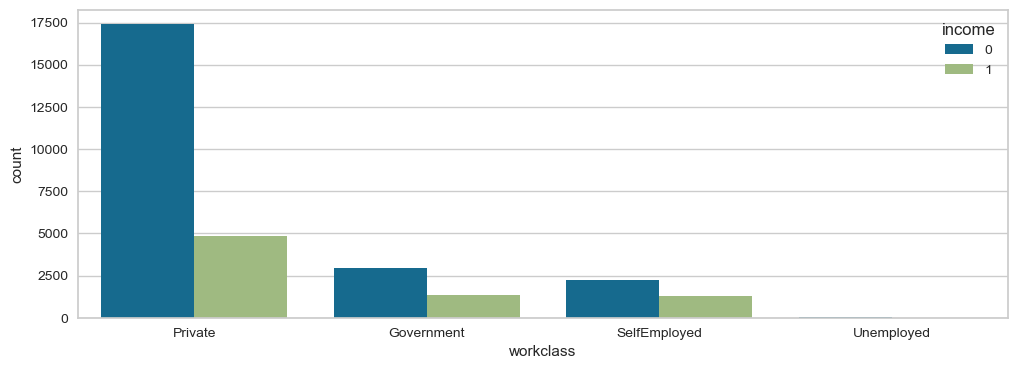

In [31]:
# Feature Creation
# Categorize existing workclass to meaningful groups
trainSet["workclass"]=trainSet["workclass"].replace(["Local-gov","State-gov","Federal-gov"],"Government")
trainSet["workclass"]=trainSet["workclass"].replace("Without-pay","Unemployed")
trainSet["workclass"]=trainSet["workclass"].replace(["Self-emp-not-inc","Self-emp-inc"],"SelfEmployed")
testSet["workclass"]=testSet["workclass"].replace(["Local-gov","State-gov","Federal-gov"],"Government")
testSet["workclass"]=testSet["workclass"].replace("Without-pay","Unemployed")
testSet["workclass"]=testSet["workclass"].replace(["Self-emp-not-inc","Self-emp-inc"],"SelfEmployed")

plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="workclass",hue="income",order=trainSet["workclass"].value_counts().index)
plt.show()

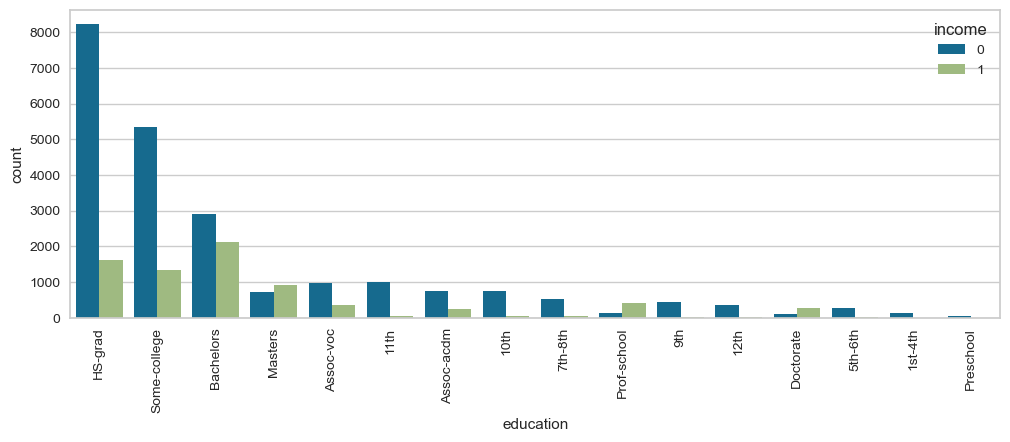

In [32]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="education",hue="income",order=trainSet["education"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

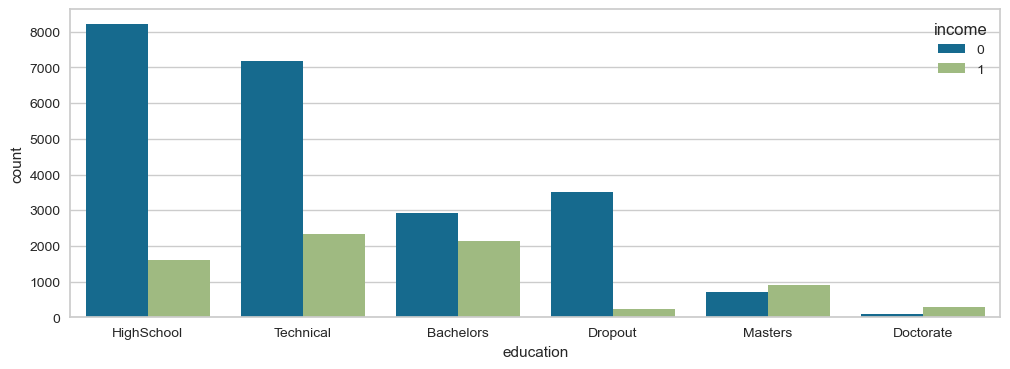

In [33]:
# Feature Creation
# People who didnot complete high school are categorized in class level which is not very relevant
# We can group them as Dropouts
trainSet["education"]=trainSet["education"].replace(["12th","11th","10th","9th","7th-8th","5th-6th","1st-4th","Preschool"],"Dropout")
trainSet["education"]=trainSet["education"].replace("HS-grad","HighSchool")
trainSet["education"]=trainSet["education"].replace(["Assoc-voc","Assoc-acdm","Prof-school","Some-college"],"Technical")
testSet["education"]=testSet["education"].replace(["12th","11th","10th","9th","7th-8th","5th-6th","1st-4th","Preschool"],"Dropout")
testSet["education"]=testSet["education"].replace("HS-grad","HighSchool")
testSet["education"]=testSet["education"].replace(["Assoc-voc","Assoc-acdm","Prof-school","Some-college"],"Technical")
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="education",hue="income",order=trainSet["education"].value_counts().index)
plt.show()
# Most people have highschool graduation and above.
# The count of Income Group above 50K increases as the education level increases.

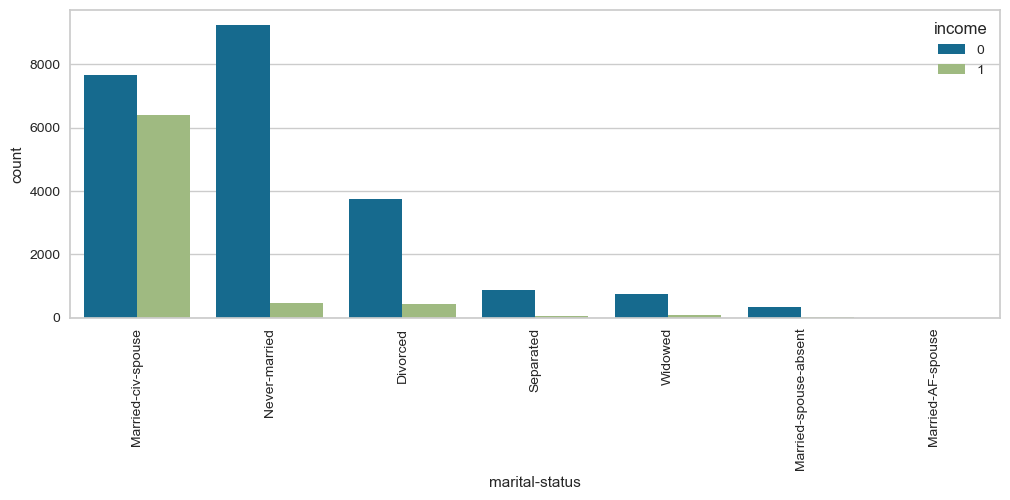

In [34]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="marital-status",hue="income",order=trainSet["marital-status"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()
# Majority of people in Income group >50K are married-civ-spouse

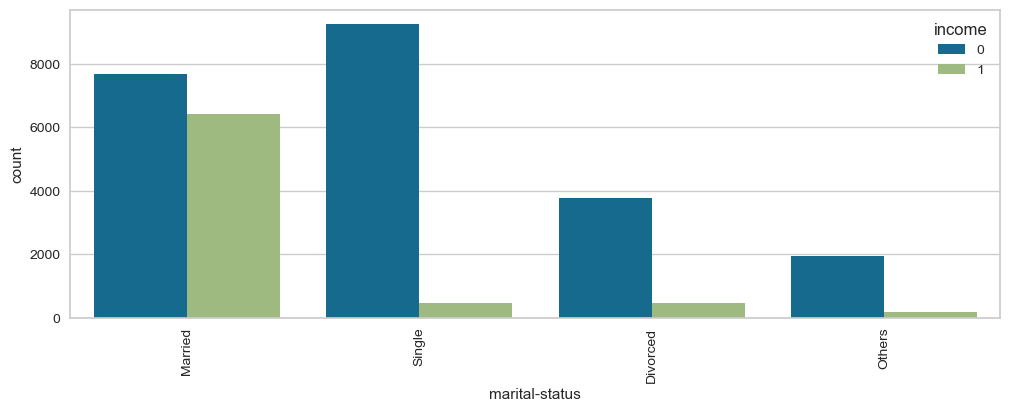

In [35]:
# Feature Creation
# Categorize existing marital status to meaningful groups
trainSet["marital-status"]=trainSet["marital-status"].replace(["Married-civ-spouse","Married-AF-spouse"],"Married")
trainSet["marital-status"]=trainSet["marital-status"].replace("Never-married","Single")
trainSet["marital-status"]=trainSet["marital-status"].replace(["Separated","Widowed","Married-spouse-absent"],"Others")
testSet["marital-status"]=testSet["marital-status"].replace(["Married-civ-spouse","Married-AF-spouse"],"Married")
testSet["marital-status"]=testSet["marital-status"].replace("Never-married","Single")
testSet["marital-status"]=testSet["marital-status"].replace(["Separated","Widowed","Married-spouse-absent"],"Others")
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="marital-status",hue="income",order=trainSet["marital-status"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

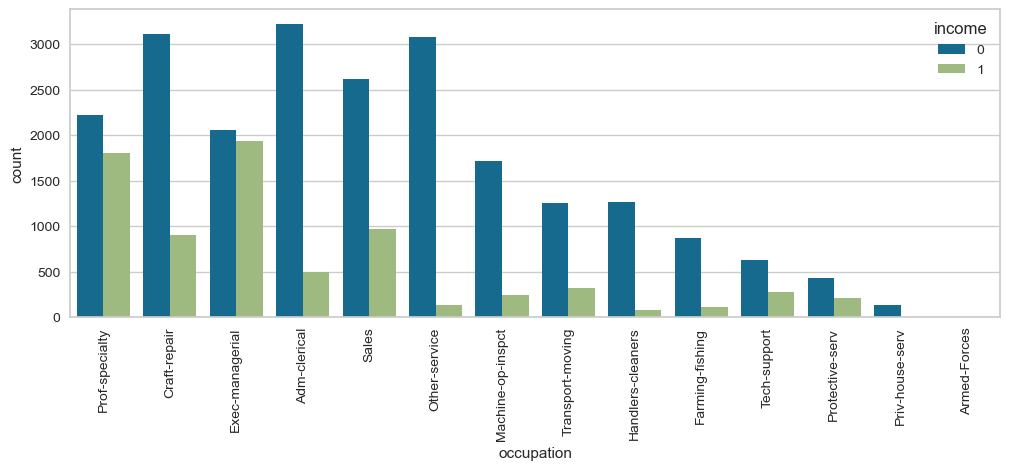

In [36]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="occupation",hue="income",order=trainSet["occupation"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

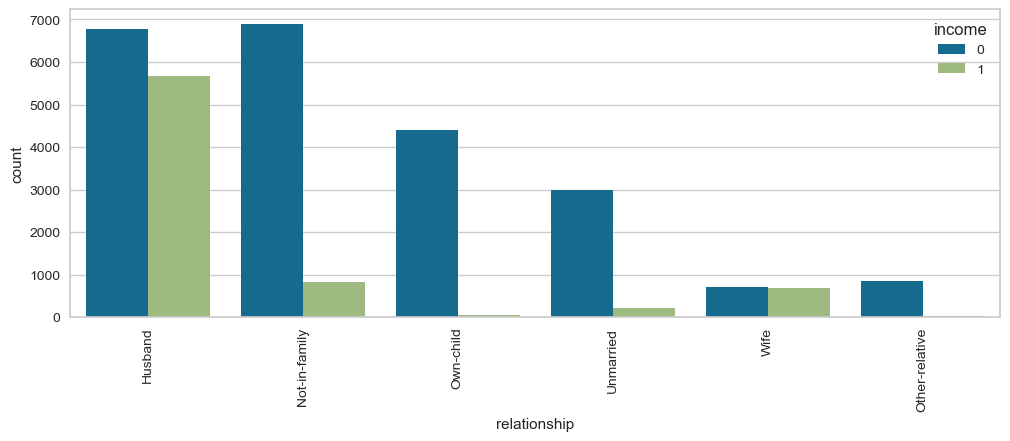

In [37]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="relationship",hue="income",order=trainSet["relationship"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()
# Majority of people in the dataset are husband

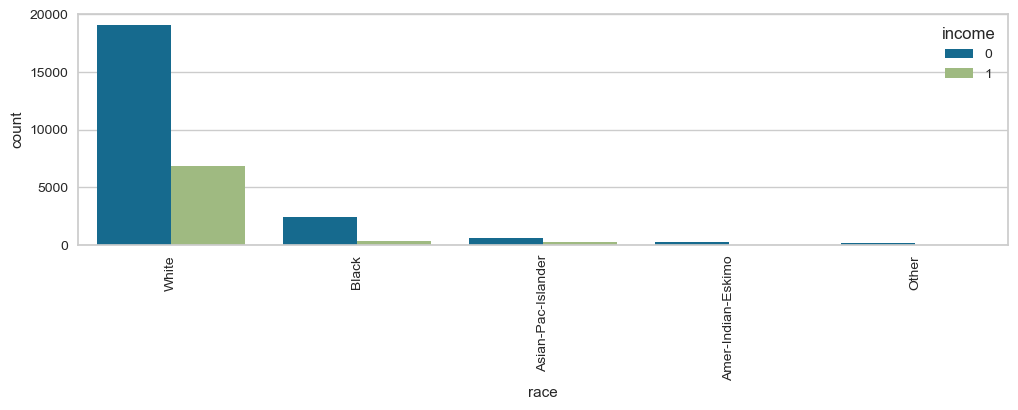

In [38]:
plt.figure(figsize=(12,3))
sns.countplot(data=trainSet,x="race",hue="income",order=trainSet["race"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()
# Majority of people in this data set is white

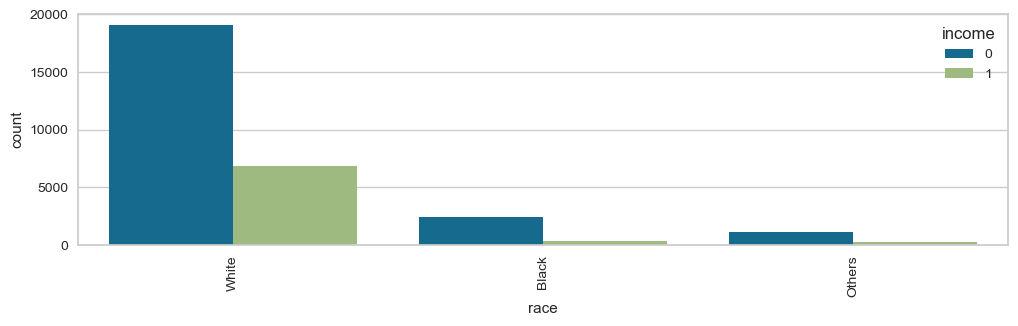

In [39]:
# Feature Creation
# Categorize existing race to white, black and others
def rename_race(race):
    if race not in ["White","Black"]:
        return "Others"
    else:
        return race
trainSet["race"]= trainSet["race"].apply(rename_race)
testSet["race"]= testSet["race"].apply(rename_race)
plt.figure(figsize=(12,3))
sns.countplot(data=trainSet,x="race",hue="income",order=trainSet["race"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

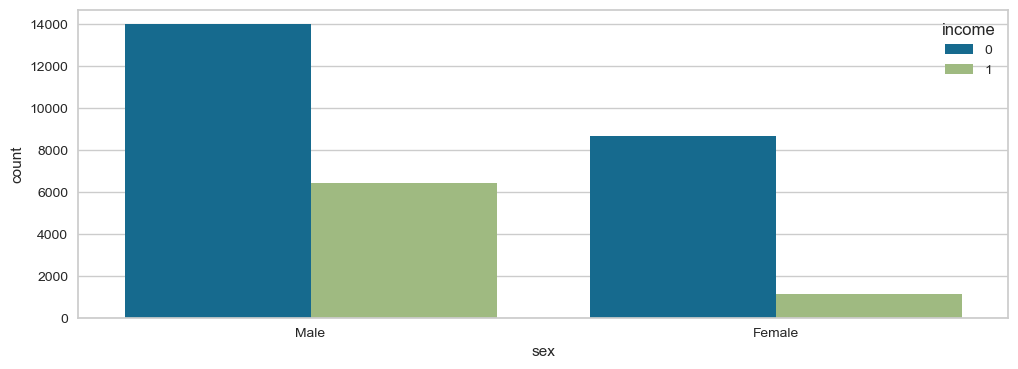

In [40]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="sex",hue="income",order=trainSet["sex"].value_counts().index)
plt.show()
# Majority of people in this data set is male.
# Most females have lower income <=50K

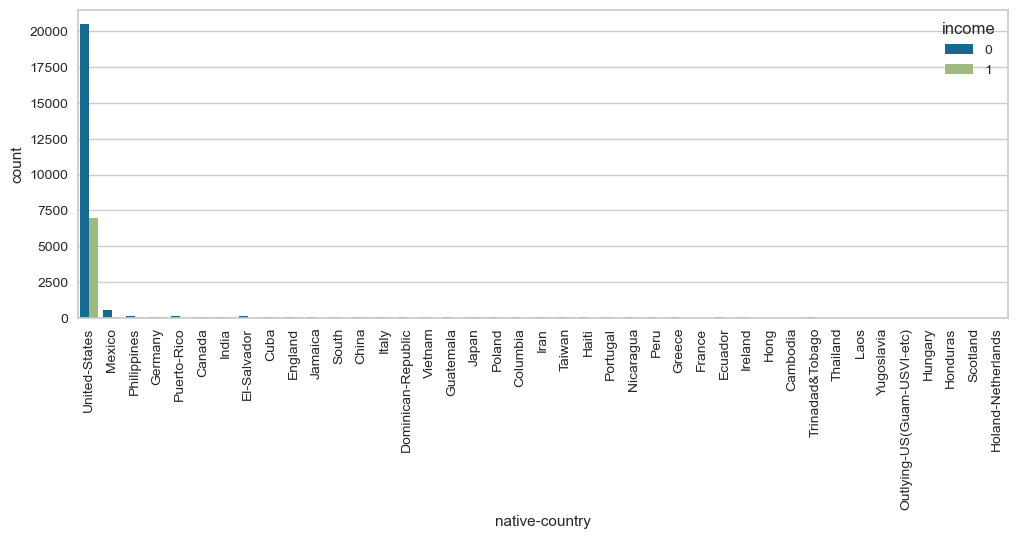

In [41]:
plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="native-country",hue="income",order=trainSet["native-country"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()
# Majority of data is based on US.

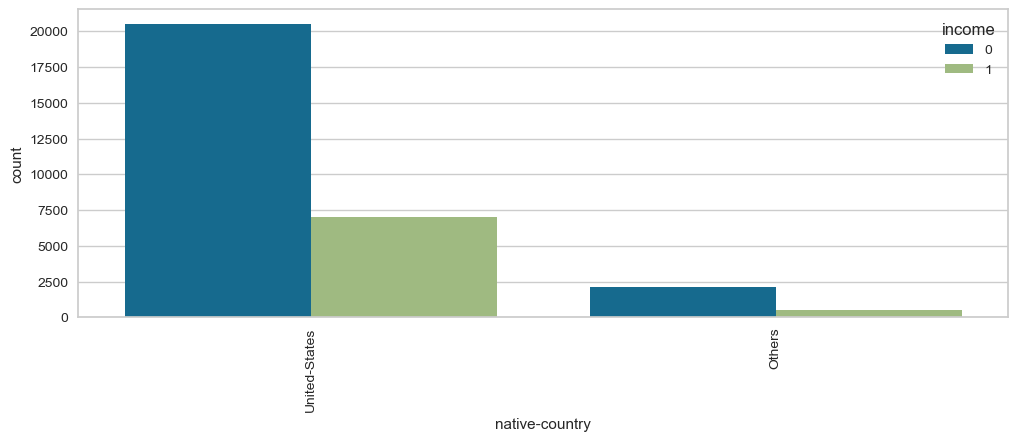

In [42]:
# Feature Creation
# Categorize existing country to US and Others
def rename_country(country):
    if country not in ["United-States"]:
        return "Others"
    else:
        return country
trainSet["native-country"]= trainSet["native-country"].apply(rename_country)
testSet["native-country"]= testSet["native-country"].apply(rename_country)

plt.figure(figsize=(12,4))
sns.countplot(data=trainSet,x="native-country",hue="income",order=trainSet["native-country"].value_counts().index)
plt.xticks(rotation = 90)
plt.show()

In [43]:
# Split Target Class and Features before Model Training
x_train = trainSet.drop("income", axis=1)
y_train = trainSet["income"]
x_test = testSet.drop("income", axis=1)
y_test = testSet["income"]

In [44]:
# Normalizing numerical features in the range of 0 to 1 to avoid creating bias based on different scales
numerical=["age","capital-loss","hours-per-week"]
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
x_train[numerical] = scaler.fit_transform(x_train[numerical])
x_test[numerical] = scaler.fit_transform(x_test[numerical])
x_train.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-loss,hours-per-week,native-country
0,0.301370,Government,Bachelors,Single,Adm-clerical,Not-in-family,White,Male,0.0,0.397959,United-States
1,0.452055,SelfEmployed,Bachelors,Married,Exec-managerial,Husband,White,Male,0.0,0.122449,United-States
2,0.287671,Private,HighSchool,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.397959,United-States
3,0.493151,Private,Dropout,Married,Handlers-cleaners,Husband,Black,Male,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,Married,Prof-specialty,Wife,Black,Female,0.0,0.397959,Others


In [45]:
x_test.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-loss,hours-per-week,native-country
0,0.109589,Private,Dropout,Single,Machine-op-inspct,Own-child,Black,Male,0.0,0.397959,United-States
1,0.287671,Private,HighSchool,Married,Farming-fishing,Husband,White,Male,0.0,0.500000,United-States
2,0.150685,Government,Technical,Married,Protective-serv,Husband,White,Male,0.0,0.397959,United-States
3,0.369863,Private,Technical,Married,Machine-op-inspct,Husband,Black,Male,0.0,0.397959,United-States
5,0.232877,Private,Dropout,Single,Other-service,Not-in-family,White,Male,0.0,0.295918,United-States


In [46]:
# Converting Catogerical data to numerical using "One hot encoding"
x_train_final=pd.get_dummies(x_train)
encoded=list(x_train_final.columns)
x_train_final.head()

,age,capital-loss,hours-per-week,workclass_Government,workclass_Private,workclass_SelfEmployed,workclass_Unemployed,education_Bachelors,education_Doctorate,education_Dropout,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Black,race_Others,race_White,sex_Female,sex_Male,native-country_Others,native-country_United-States
0,0.301370,0.0,0.397959,1,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
1,0.452055,0.0,0.122449,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1
2,0.287671,0.0,0.397959,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,0.493151,0.0,0.397959,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,1,0,1
4,0.150685,0.0,0.397959,0,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,1,0


In [47]:
# Converting Catogerical data to numerical using "One hot encoding"
x_test_final=pd.get_dummies(x_test)
encoded=list(x_test_final.columns)
x_test_final.head()

,age,capital-loss,hours-per-week,workclass_Government,workclass_Private,workclass_SelfEmployed,workclass_Unemployed,education_Bachelors,education_Doctorate,education_Dropout,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Black,race_Others,race_White,sex_Female,sex_Male,native-country_Others,native-country_United-States
0,0.109589,0.0,0.397959,0,1,0,0,0,0,1,...,1,0,0,1,0,0,0,1,0,1
1,0.287671,0.0,0.500000,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
2,0.150685,0.0,0.397959,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
3,0.369863,0.0,0.397959,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
5,0.232877,0.0,0.295918,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,1


# Classification Model: Random Forest Classifier

In [48]:
#model = tree.DecisionTreeClassifier(max_depth=10)
#model = model.fit(x_train_final,y_train)
#train_predict = model.predict(x_train_final)
#test_predict = model.predict(x_test_final)
#print("Accuracy Score - train Data: {}".format(accuracy_score(y_train,train_predict,normalize=True,sample_weight=None)))
#print("Accuracy Score - test Data: {}".format(accuracy_score(y_test,test_predict,normalize=True,sample_weight=None)))
#print(classification_report(y_test, test_predict))

In [49]:
# Model Training using RandomForestClassifier with default parameter and training dataset
model = RandomForestClassifier()
model = model.fit(x_train_final,y_train)
train_predict = model.predict(x_train_final)
test_predict = model.predict(x_test_final)
print("Accuracy Score - Train Data: {}".format(accuracy_score(y_train,train_predict,normalize=True,sample_weight=None)))
print("Accuracy Score - Test Data: {}".format(accuracy_score(y_test,test_predict,normalize=True,sample_weight=None)))
print("")

# Model Evaluation on Train DataSet
print(style.boldStart+"Model Evaluation on Train DataSet"+style.boldEnd)
cm = confusion_matrix(y_train, train_predict)
print(style.boldStart+"Confusion matrix\n"+style.boldEnd, cm)
print(style.boldStart+"\nClassification Report"+style.boldEnd)
print(classification_report(y_train, train_predict))

Accuracy Score - Train Data: 0.9602176581837486
Accuracy Score - Test Data: 0.8045831949518433

Model Evaluation on Train DataSet
Confusion matrix
 [[22100   533]
 [  666  6840]]

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97     22633
           1       0.93      0.91      0.92      7506

    accuracy                           0.96     30139
   macro avg       0.95      0.94      0.95     30139
weighted avg       0.96      0.96      0.96     30139



In [50]:
# Model Evaluation on Test DataSet
print(style.boldStart+"Model Evaluation on Test DataSet"+style.boldEnd)
cm = confusion_matrix(y_test, test_predict)
print(style.boldStart+"Confusion matrix\n"+style.boldEnd, cm)
print(style.boldStart+"\nClassification Report"+style.boldEnd)
print(classification_report(y_test, test_predict))

Model Evaluation on Test DataSet
Confusion matrix
 [[10133  1222]
 [ 1720  1980]]

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.89      0.87     11355
           1       0.62      0.54      0.57      3700

    accuracy                           0.80     15055
   macro avg       0.74      0.71      0.72     15055
weighted avg       0.80      0.80      0.80     15055



In [51]:
# Current Hyperparameters for RandomForestClassifier
print(model.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [52]:
# Tuning Hyperparameters for RandomForestClassifier with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Creating hyperparameters grid for Random Forest
param_grid = {
    "n_estimators": np.arange(50, 501, 50),
    "max_depth": np.arange(5, 21, 5),
    "min_samples_split": np.arange(2, 21, 2),
    "min_samples_leaf": np.arange(1, 21, 2),
    "bootstrap": [True, False],
    "max_features": ["auto", "sqrt"]
}

# Creating the RandomizedSearchCV object for Random Forest and fitting the random search model with training dataset
rs = RandomizedSearchCV(model, param_grid, n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)
rs.fit(x_train_final,y_train)

# Getting the best parameters and the best score
best_params = rs.best_params_
best_score = rs.best_score_
best_params, best_score

Fitting 5 folds for each of 50 candidates, totalling 250 fits


({'n_estimators': 50,
  'min_samples_split': 16,
  'min_samples_leaf': 5,
  'max_features': 'sqrt',
  'max_depth': 20,
  'bootstrap': True},
 0.8391784690635118)

In [53]:
# Applying tuned hyperparameters
model = RandomForestClassifier(random_state=0,n_estimators=200,min_samples_split=20
                               ,min_samples_leaf=5,max_features="sqrt",max_depth=20,bootstrap=False)
model = model.fit(x_train_final,y_train)
train_predict = model.predict(x_train_final)
test_predict = model.predict(x_test_final)
print("Accuracy Score - train Data: {}".format(accuracy_score(y_train,train_predict,normalize=True,sample_weight=None)))
print("Accuracy Score - test Data: {}".format(accuracy_score(y_test,test_predict,normalize=True,sample_weight=None)))
print("")

# Model Evaluation on Train DataSet
print(style.boldStart+"Model Evaluation on Train DataSet"+style.boldEnd)
cm = confusion_matrix(y_train, train_predict)
print(style.boldStart+"Confusion matrix\n"+style.boldEnd, cm)
print(style.boldStart+"\nClassification Report"+style.boldEnd)
print(classification_report(y_train, train_predict))

Accuracy Score - train Data: 0.8579249477421281
Accuracy Score - test Data: 0.8314181335104617

Model Evaluation on Train DataSet
Confusion matrix
 [[21221  1412]
 [ 2870  4636]]

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22633
           1       0.77      0.62      0.68      7506

    accuracy                           0.86     30139
   macro avg       0.82      0.78      0.80     30139
weighted avg       0.85      0.86      0.85     30139



In [54]:
# Model Evaluation on Test DataSet
print(style.boldStart+"Model Evaluation on Test DataSet"+style.boldEnd)
cm = confusion_matrix(y_test, test_predict)
print(style.boldStart+"Confusion matrix\n"+style.boldEnd, cm)
print(style.boldStart+"\nClassification Report"+style.boldEnd)
print(classification_report(y_test, test_predict))

Model Evaluation on Test DataSet
Confusion matrix
 [[10503   852]
 [ 1686  2014]]

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     11355
           1       0.70      0.54      0.61      3700

    accuracy                           0.83     15055
   macro avg       0.78      0.73      0.75     15055
weighted avg       0.82      0.83      0.82     15055



# Clustering Model: K-Means

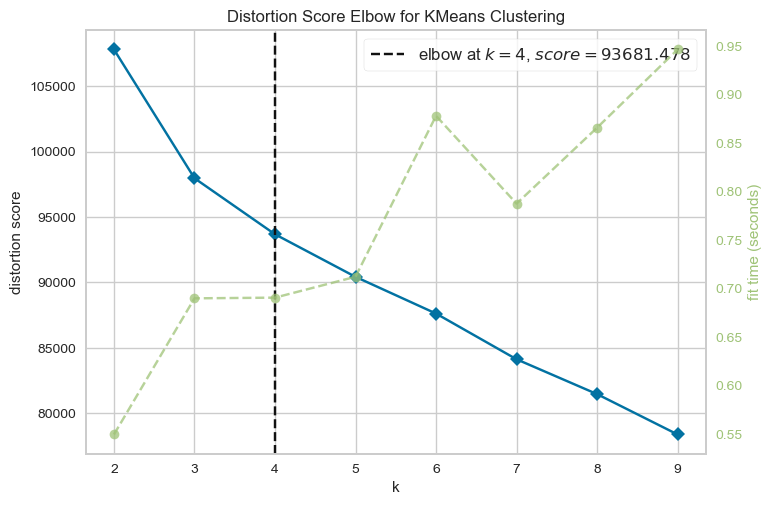

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
# For K-Means clustering it is quite important to determine the number of clusters
# Elbow Method using Distortion Score metric to determine optimum number of clusters
model = KMeans(n_init=10)
kev = KElbowVisualizer(model, k=(2,10)) 
kev.fit(x_train_final)
kev.show()

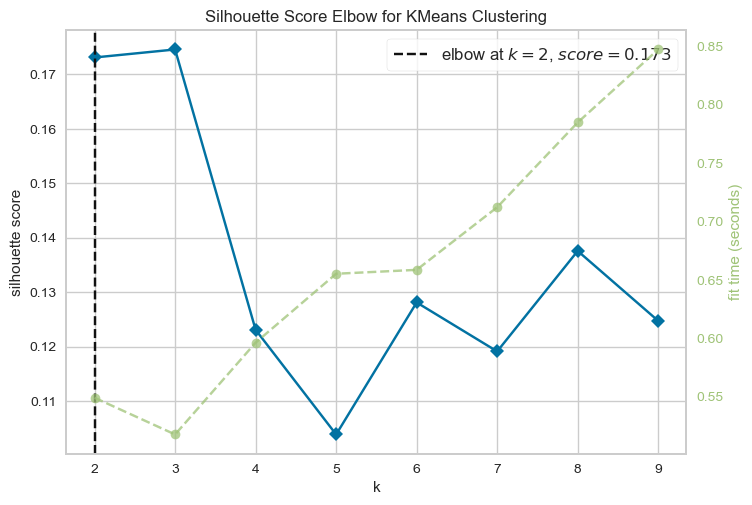

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [56]:
# For K-Means clustering it is quite important to determine the number of clusters
# Elbow Method using Silhouette Score metric to determine optimum number of clusters
model = KMeans(n_init=10)
kev = KElbowVisualizer(model, k=(2,10),metric='silhouette') 
kev.fit(x_train_final)
kev.show()

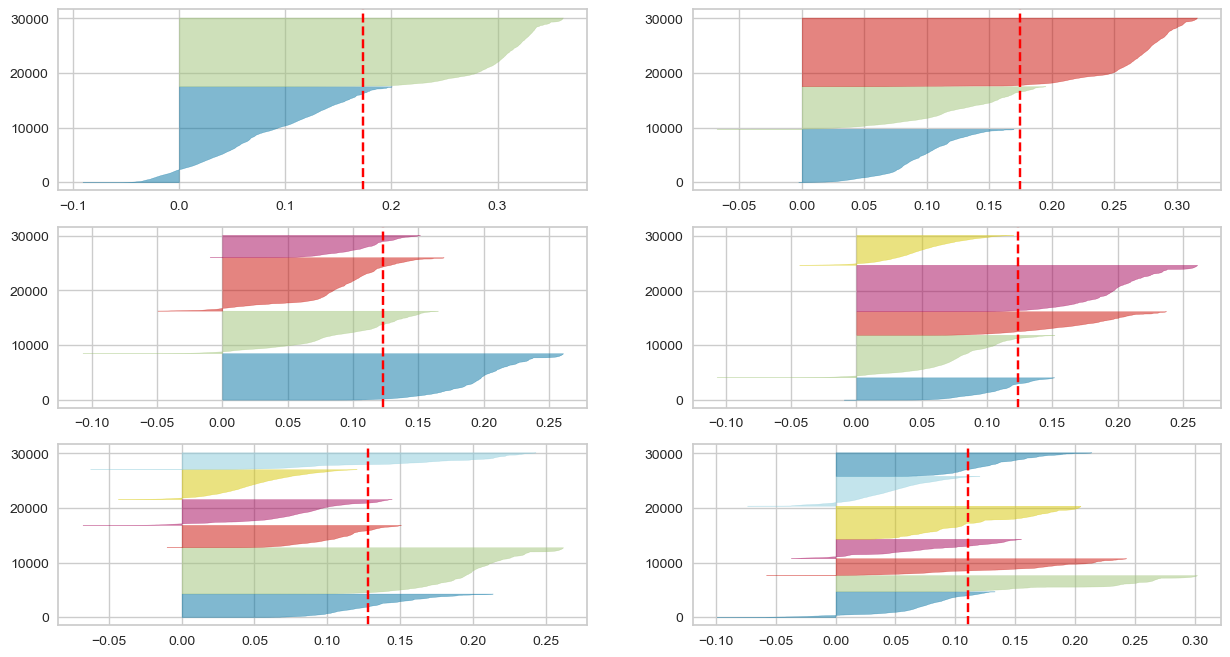

In [57]:
# Using the Silhouette Visualizer to display the silhouette coefficient for each sample on a per-cluster basis
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    model = KMeans(n_clusters=i, n_init=10)
    q, mod = divmod(i, 2)
    sv = SilhouetteVisualizer(model, colors="yellowbrick", ax=ax[q-1][mod])
    sv.fit(x_train_final) 

In [58]:
# Model Training using Training Dataset, k=2
model1 = KMeans(n_clusters = 2, n_init=10)
model1.fit(x_train_final)

print("Cluster Centers:")
print(model1.cluster_centers_)

# predict training data
train_pred1 = model1.predict(x_train_final)

Cluster Centers:
[[ 3.57858891e-01  4.41501371e-02  4.44403280e-01  1.41733535e-01
   6.75776595e-01  1.82092635e-01  3.97235243e-04  1.84714388e-01
   1.90672917e-02  1.10908080e-01  3.25097323e-01  6.63382855e-02
   2.93874633e-01 -1.49880108e-15  1.00000000e+00  4.16333634e-16
  -9.65894031e-15  4.81449114e-02  2.38341146e-04  1.98379280e-01
   1.71287837e-01  4.44903472e-02  3.49567014e-02  6.95161675e-02
   4.06768889e-02  7.94470485e-05  1.39667911e-01  2.95543021e-02
   1.18693891e-01  2.76475729e-02  7.66664018e-02  9.89671884e-01
   7.94470485e-04  5.56129340e-03  3.89290538e-03  1.30451205e-15
   7.94470485e-05  4.98132994e-02  4.29808533e-02  9.07205847e-01
   7.94470485e-05  9.99920553e-01  8.62794947e-02  9.13720505e-01]
 [ 2.47728082e-01  2.15221577e-02  3.81030477e-01  1.42718778e-01
   7.83842297e-01  7.29261623e-02  5.12762078e-04  1.54797174e-01
   7.69143118e-03  1.33318140e-01  3.27142206e-01  4.50660893e-02
   3.31984959e-01  2.39972653e-01  8.50615314e-02  1.21695

In [59]:
# Model Training using Training Dataset, k=4
model2 = KMeans(n_clusters = 4, n_init=10)
model2.fit(x_train_final)

print("Cluster Centers:")
print(model2.cluster_centers_)

# predict training data
train_pred2 = model2.predict(x_train_final)

Cluster Centers:
[[ 3.38279792e-01  4.12901514e-02  4.39790878e-01  3.88578059e-15
   1.00000000e+00 -1.92901251e-15 -4.98732999e-18  1.79134321e-01
   1.30557516e-02  1.25264644e-01  3.42390026e-01  5.48106328e-02
   2.85344625e-01 -1.47104551e-15  1.00000000e+00  3.88578059e-16
  -3.38618023e-15  4.56363209e-02  1.30104261e-18  2.22653493e-01
   1.54551870e-01  2.18772054e-02  4.69301341e-02  9.77417078e-02
   4.34015526e-02  1.17619384e-04  1.14326041e-01  1.03505058e-02
   1.22912256e-01  3.16396142e-02  8.78616796e-02  9.88708539e-01
   4.70477535e-04  6.11620795e-03  4.58715596e-03  1.22124533e-15
   1.17619384e-04  5.08115737e-02  4.37544107e-02  9.05434016e-01
   1.17619384e-04  9.99882381e-01  9.57421783e-02  9.04257822e-01]
 [ 2.16407019e-01  2.25889570e-02  3.99140764e-01  1.14124149e-01
   7.87816476e-01  9.75453027e-02  5.14072741e-04  1.53579231e-01
   6.93998201e-03  1.57177741e-01  3.39288009e-01  3.63706464e-02
   3.06644390e-01  2.16553142e-01  7.71109112e-04  8.79064

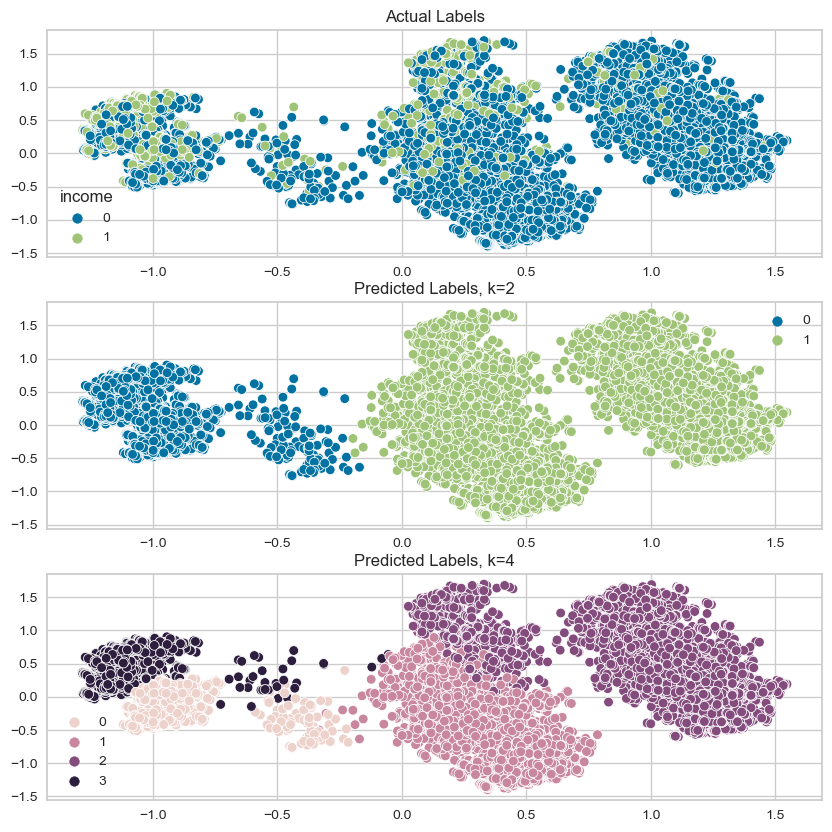

In [60]:
# Use PCA to plot Training dataset cluster on 2 dimensional space
pca = PCA(n_components = 2)

# Model and fit the training dataset to the PCA model
train_pca = pca.fit_transform(x_train_final)

# Visualize actual vs predicted training labels. 
x = train_pca[:, 0]
y = train_pca[:, 1]

plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.title("Actual Labels")
sns.scatterplot(x = x, y = y, hue = y_train)
plt.subplot(312)
plt.title("Predicted Labels, k=2")
sns.scatterplot(x = x, y = y, hue = train_pred1);
plt.subplot(313)
plt.title("Predicted Labels, k=4")
sns.scatterplot(x = x, y = y, hue = train_pred2);

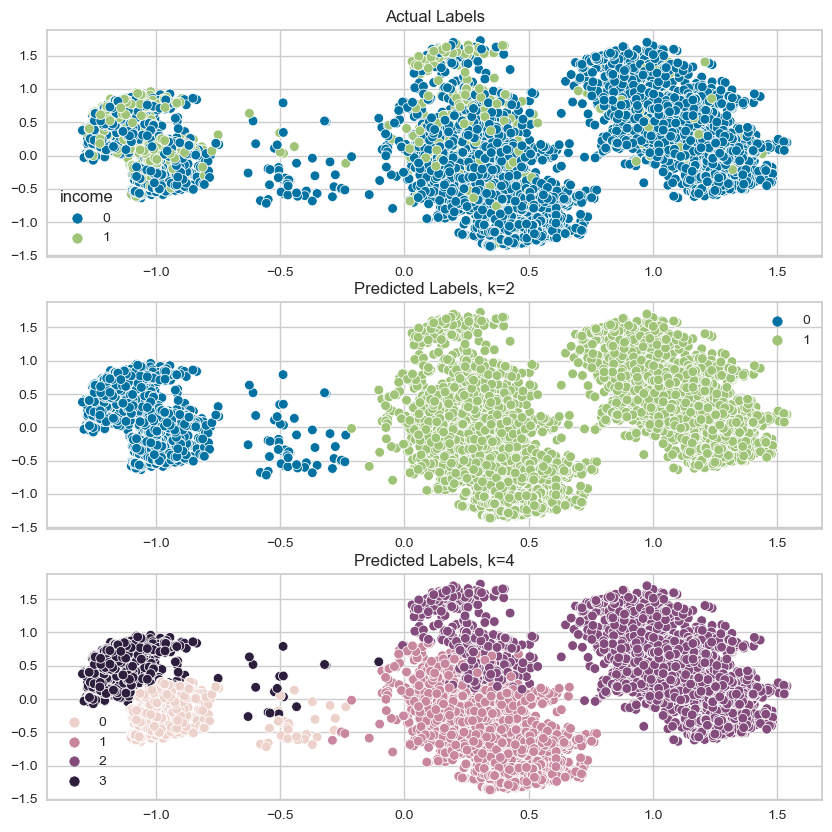

In [61]:
# Use PCA to plot Test dataset cluster on 2 dimensional space

# Model and fit the test dataset to the PCA model
test_pred1 = model1.predict(x_test_final)
test_pred2 = model2.predict(x_test_final)
test_pca = pca.fit_transform(x_test_final)

# Visualize actual vs predicted test labels.  
x = test_pca[:, 0]
y = test_pca[:, 1]

plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.title("Actual Labels")
sns.scatterplot(x = x, y = y, hue = y_test)
plt.subplot(312)
plt.title("Predicted Labels, k=2")
sns.scatterplot(x = x, y = y, hue = test_pred1);
plt.subplot(313)
plt.title("Predicted Labels, k=4")
sns.scatterplot(x = x, y = y, hue = test_pred2);

In [64]:
# Model Evaluation on Train DataSet
print(style.boldStart+"Model Evaluation on Train DataSet"+style.boldEnd)
cm = confusion_matrix(y_train, train_predict)
print(style.boldStart+"Confusion matrix\n"+style.boldEnd, cm)
print(style.boldStart+"\nClassification Report"+style.boldEnd)
print(classification_report(y_train, train_pred1))

Model Evaluation on Train DataSet
Confusion matrix
 [[21221  1412]
 [ 2870  4636]]

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.30      0.39     22633
           1       0.10      0.24      0.14      7506

    accuracy                           0.29     30139
   macro avg       0.32      0.27      0.27     30139
weighted avg       0.44      0.29      0.33     30139



In [66]:
# Model Evaluation on Train DataSet
print(style.boldStart+"Model Evaluation on Train DataSet"+style.boldEnd)
cm = confusion_matrix(y_train, train_predict)
print(style.boldStart+"Confusion matrix\n"+style.boldEnd, cm)
print(style.boldStart+"\nClassification Report"+style.boldEnd)
print(classification_report(y_test, test_pred1))

Model Evaluation on Train DataSet
Confusion matrix
 [[21221  1412]
 [ 2870  4636]]

Classification Report
              precision    recall  f1-score   support

           0       0.55      0.30      0.39     11355
           1       0.10      0.23      0.14      3700

    accuracy                           0.28     15055
   macro avg       0.32      0.27      0.26     15055
weighted avg       0.44      0.28      0.33     15055

